# MVP

In [1]:
# General Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# AWS Libraries
import logging
import boto3
from botocore.exceptions import ClientError

# NLP Libraries
import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Geo-mapping Libraries
import geopandas
import geopy
import folium 

# Helper Functions
import MVP_acquire_ds, MVP_explore

# Skill Libray
import library

import warnings
warnings.filterwarnings("ignore")

## Data Acquisition

### Download the JSON Files from AWS S3 Bucket

In [2]:
%%time

# Create the s3 resource object
s3 = boto3.resource('s3')

# Download the json files from AWS

s3.Bucket("dspreparedjobpostings").download_file("df_ds_tx_prepared_backup.json", 
                                                 "df_ds_tx_prepared_backup.json")

s3.Bucket("wdpreparedjobpostings").download_file("df_wd_tx_prepared_backup.json", 
                                                 "df_wd_tx_prepared_backup.json")

# Print the last modified datetime of the prepared file of data scientist positions in TX
print("Last modified datetime for data scientist positions in TX: ", 
      s3.Object('dspreparedjobpostings', 'df_ds_tx_prepared_backup.json').last_modified)

# Print the last modified datetime of the prepared file of web developer positions in TX
print("Last modified datetime for web developer positions in TX: ", 
      s3.Object('wdpreparedjobpostings', 'df_wd_tx_prepared_backup.json').last_modified)

Last modified datetime for data scientist positions in TX:  2021-05-14 02:01:20+00:00
Last modified datetime for web developer positions in TX:  2021-05-14 02:07:24+00:00
CPU times: user 856 ms, sys: 453 ms, total: 1.31 s
Wall time: 5.62 s


### Load JSON Files into Dataframe

In [3]:
# Read the json file into pandas dataframe

df_ds = pd.read_json('df_ds_tx_prepared_backup.json')
df_wd = pd.read_json('df_wd_tx_prepared_backup.json')

# Print the number of job postings in each dataframe

print("Number of job postings for data scientists in TX since 2020-12-22: ", df_ds.shape[0])
print("Number of job postings for web developers in TX since 2021-01-04 ", df_wd.shape[0])

Number of job postings for data scientists in TX since 2020-12-22:  5072
Number of job postings for web developers in TX since 2021-01-04  10244


In [4]:
# Print the concise summary of the job postings for data scientists
df_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5072 entries, 0 to 5071
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             5072 non-null   datetime64[ns]
 1   title            5072 non-null   object        
 2   company          5072 non-null   object        
 3   company_rating   5072 non-null   float64       
 4   job_link         5072 non-null   object        
 5   job_description  5072 non-null   object        
 6   city             5072 non-null   object        
 7   state            5072 non-null   object        
 8   zipcode          5072 non-null   int64         
 9   clean            5072 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 396.4+ KB


In [5]:
# Print the most recent 5 job postings for data scientists
df_ds.head()

,date,title,company,company_rating,job_link,job_description,city,state,zipcode,clean
0,2021-05-13,Sr. Software Engineer - RF Data Analyst / Perl...,Raytheon,3.90,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,We have an exciting opportunity for a Sr. Soft...,Dallas,TX,75221,exciting opportunity sr software engineer rf d...
1,2021-05-13,Data Scientist-- AI experience--132405-1,Solize USA Corporation,3.78,https://www.indeed.com/company/CSM-Sostware-US...,Senior AI EngineerREQUIRED:-Masters or PhD in ...,Austin,TX,78753,senior ai engineerrequiredmasters phd computer...
2,2021-05-13,Artificial Intelligence Engineer - Watson AI E...,IBM,3.90,https://www.indeed.com/rc/clk?jk=ad17c764a7bff...,"Introduction\nAs a Data Scientist at IBM, you ...",Austin,TX,73301,introduction data scientist ibm help transform...
3,2021-05-13,Data Scientist,Data Rocket,3.78,https://www.indeed.com/rc/clk?jk=f5ff297d959b3...,Data Scientist | Multiple Positions\n\nJob Des...,Dallas-Fort Worth,TX,0,data scientist multiple position job descripti...
4,2021-05-13,"Manager, Data Scientist",KPMG,4.00,https://www.indeed.com/rc/clk?jk=315c53f920512...,Innovate. Collaborate. Build. Create. Solve. T...,Dallas,TX,0,innovate collaborate build create solve kpmg d...


In [6]:
# Print the concise summary of the job postings for web developers
df_wd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10244 entries, 0 to 10243
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             10244 non-null  datetime64[ns]
 1   title            10244 non-null  object        
 2   company          10244 non-null  object        
 3   company_rating   10244 non-null  float64       
 4   job_link         10244 non-null  object        
 5   job_description  10244 non-null  object        
 6   city             10244 non-null  object        
 7   state            10244 non-null  object        
 8   zipcode          10244 non-null  int64         
 9   clean            10244 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 800.4+ KB


In [7]:
# Print the most recent 5 job postings for web developers
df_wd.head()

,date,title,company,company_rating,job_link,job_description,city,state,zipcode,clean
0,2021-05-13,"Associate Developer, IT Applications",American Airlines,4.0,https://www.indeed.com/rc/clk?jk=555cbef50d777...,Location: DFW Headquarters Building 8 (DFW-SV0...,Fort Worth,TX,0,location dfw headquarters building 8 dfwsv08 a...
1,2021-05-13,Full Stack Software Engineer,Eagle Eye Networks,3.9,https://www.indeed.com/rc/clk?jk=09e279459ffcf...,About Eagle Eye Networks:\n\nEagle Eye Network...,Austin,TX,73344,eagle eye network eagle eye network world lead...
2,2021-05-13,Senior Software Engineer,AT&T,3.7,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"About the Company\nAt AT&T, we’re connecting t...",Dallas,TX,75221,company att connecting world latest tech topof...
3,2021-05-13,Software Engineer,CBRE,3.7,https://www.indeed.com/rc/clk?jk=b13219b18eab0...,Posted\n13-05-2021\nService line\nAdvisory Seg...,Dallas,TX,0,posted 13052021 service line advisory segment ...
4,2021-05-13,Front End Web Developer,Aquent,4.0,https://www.indeed.com/cmp/Aquent,error,Houston,TX,0,error


## Data Preparation

### Consolidation

In [8]:
# Create a job code column: set value 0 for data scientis and 1 for web developers

df_ds = df_ds.assign(job_code = "data scientist")
df_wd = df_wd.assign(job_code = "web developer")

# Concat the two dataframes
df = pd.concat([df_ds, df_wd])

# Inspect the new dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15316 entries, 0 to 10243
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             15316 non-null  datetime64[ns]
 1   title            15316 non-null  object        
 2   company          15316 non-null  object        
 3   company_rating   15316 non-null  float64       
 4   job_link         15316 non-null  object        
 5   job_description  15316 non-null  object        
 6   city             15316 non-null  object        
 7   state            15316 non-null  object        
 8   zipcode          15316 non-null  int64         
 9   clean            15316 non-null  object        
 10  job_code         15316 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(8)
memory usage: 1.4+ MB


In [9]:
# Set the date as the index and sort in a descending order
df = df.set_index('date').sort_index(ascending=False)

# Rename the columns to be easily understood
df = df.rename(columns={'title': 'job_title', 'clean': 'cleaned_job_description'})

# Inspect the first 5 rows
df.head()

,job_title,company,company_rating,job_link,job_description,city,state,zipcode,cleaned_job_description,job_code
date,,,,,,,,,,
2021-05-13,Sr. Software Engineer - RF Data Analyst / Perl...,Raytheon,3.9,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,We have an exciting opportunity for a Sr. Soft...,Dallas,TX,75221,exciting opportunity sr software engineer rf d...,data scientist
2021-05-13,Enterprise Software Engineer,Apptricity Corporation,2.7,https://www.indeed.com/company/Apptricity-Corp...,The Enterprise Software Engineer is responsibl...,Irving,TX,75039,enterprise software engineer responsible contr...,web developer
2021-05-13,"Sr. SW Engineer, Web QA Automation",Roku,3.1,https://www.indeed.com/rc/clk?jk=7229aa41f6f96...,Get your hands on the application framework th...,Austin,TX,0,get hand application framework make 53 million...,web developer
2021-05-13,Full Stack Frontend Engineer,Science 37,2.8,https://www.indeed.com/rc/clk?jk=dacc6703d2ca3...,This is a fully Remote and Work From Home (WFH...,Dallas,TX,0,fully remote work home wfh opportunity within ...,web developer
2021-05-13,Senior Salesforce Software Developer,Charles Schwab,4.0,https://www.indeed.com/rc/clk?jk=6b552e1659525...,Your Opportunity\nCharles Schwab is looking fo...,Westlake,TX,0,opportunity charles schwab looking senior sale...,web developer


**Takeaways**
1. Some zipcodes are 0, which indicates they are not provided by the employers.
2. Some values in `city` column are 'Remote', which indicates the jobs do not require a specific location. 
3. So far, all the jobs are located in TX beside the remote ones and the `state` column is kept for geospacial analysis. 

### Handle Missing Values

In [10]:
# Count the missing values in each column
df.isnull().sum(axis=0)

job_title                  0
company                    0
company_rating             0
job_link                   0
job_description            0
city                       0
state                      0
zipcode                    0
cleaned_job_description    0
job_code                   0
dtype: int64

**Takeaways**: No null values has been found in the job postings. 

#### Zipcode

In [11]:
# How many zipcodes are not availabe?
df.zipcode.value_counts(normalize=True).head(1)

0    0.529316
Name: zipcode, dtype: float64

**Takeaways**
1. 53% of the zipcodes are not provided. 
2. How to handle the zipcodes with value 0?
    - option 1: drop the entire column because the ratio of the missing values is more than 50%.
    - option 2: drop the rows but we will lose half of the data. 
    - option 3: impute by the company and its location and it may need outside resource.
3. We choose to drop the `zipcode` column because our dashboard doesn't need the zipcode level of details.

In [12]:
# Drop the zipcode column

df = df.drop(columns='zipcode')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15316 entries, 2021-05-13 to 2020-12-22
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   job_title                15316 non-null  object 
 1   company                  15316 non-null  object 
 2   company_rating           15316 non-null  float64
 3   job_link                 15316 non-null  object 
 4   job_description          15316 non-null  object 
 5   city                     15316 non-null  object 
 6   state                    15316 non-null  object 
 7   cleaned_job_description  15316 non-null  object 
 8   job_code                 15316 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.2+ MB


#### City

In [13]:
# How many jobs are categorized as "Remote" in city column?

num_remote = (df.city == 'Remote').sum()
num_jobs = df.shape[0]
print(f"{num_remote} jobs are remote, which is {round(num_remote*100/num_jobs, 1)}% of all the job postings.")

891 jobs are remote, which is 5.8% of all the job postings.


**Takeaways**: We will keep the remote jobs and compare their requirements with that of the unremote jobs.

In [14]:
# We noticed that some job titles also contains word "Remote"

mask_remote = ["Remote" in i for i in df.job_title]
print(f"{sum(mask_remote)} job titles contains word 'Remote'")
df[mask_remote].job_title.head()

659 job titles contains word 'Remote'


date
2021-05-13    Senior Web & Mobile App Developer (full stack)...
2021-05-13                       Sr. Software Engineer - Remote
2021-05-13                  Senior React/Node Engineer (Remote)
2021-05-13    Software Engineer - Opportunity for Working Re...
2021-05-13    Modeling Analyst Senior - CECL Modeling (100% ...
Name: job_title, dtype: object

**Takeaways**: We will change their values in the city column to "Remote" and recompute the percentage of the remote jobs.

In [15]:
# Define a function to change the city in a job posting to "Remote" 
# if word "Remote" is found in the job title

def identify_remote_jobs(job_posting):
    if "Remote" in job_posting.job_title:
        job_posting.city = "Remote"
    return job_posting

In [16]:
%%time
# Change city to "Remote" if job title contains word "Remote"
df = df.apply(identify_remote_jobs, axis=1)

CPU times: user 1.11 s, sys: 30.7 ms, total: 1.14 s
Wall time: 1.14 s


In [17]:
# How many jobs are remote after the adjustment? 
num_remote = (df.city == 'Remote').sum()
print(f"{num_remote} jobs are remote, which is {round(num_remote*100/num_jobs, 1)}% of all the job postings.")

1471 jobs are remote, which is 9.6% of all the job postings.


#### Job Description

In [18]:
# How many job descriptions are missing?

num_missing = (df.job_description == 'error').sum()

print(f"{num_missing} jobs show 'error' in their descriptions, \
which is {round(num_missing*100/num_jobs, 1)}% of all the job postings.")

557 jobs show 'error' in their descriptions, which is 3.6% of all the job postings.


**Takeaways**
1. The value 'error' shows in the `job_descripion` column if the response is Nonetype when making a request to a detailed job posting page. 
2. Because only a small portion (less than 5%) are without the job description, we decide to keep those postings. 

### Clean Job Titles

In [19]:
# Count the frequency of a job title and list the top 20
df.job_title.value_counts().head(20)

Data Scientist                  488
Web Developer                   240
Software Engineer               218
Senior Data Scientist           186
Senior Software Engineer        169
Software Developer              153
Full Stack Developer            144
Front End Developer             140
Machine Learning Engineer       116
Java Developer                  109
Senior Data Analyst             102
UI Developer                     96
.Net Developer                   79
Sr. Data Scientist               74
Data Engineer                    68
PHP Developer                    66
Front End Engineer               66
Web Designer                     65
Senior Software Developer        63
Full Stack Software Engineer     60
Name: job_title, dtype: int64

**Takeaways**: Some senior positions use the abbreviation of senior - 'Sr.' in the job titles. We decide to use the full spelling so the 'Sr.' need to be replaced with 'Senior'.

In [20]:
# Replace 'Sr.' with 'Senior'
df.job_title = df.job_title.str.replace('Sr.', 'Senior')

# Re-Count the frequency of a job title and list the top 20
df.job_title.value_counts().head(20) 

Data Scientist                  488
Senior Data Scientist           260
Web Developer                   240
Software Engineer               218
Senior Software Engineer        202
Senior Data Analyst             154
Software Developer              153
Full Stack Developer            144
Front End Developer             140
Machine Learning Engineer       116
Java Developer                  109
UI Developer                     96
.Net Developer                   79
Data Engineer                    68
Senior Software Developer        66
Front End Engineer               66
PHP Developer                    66
Web Designer                     65
Full Stack Software Engineer     60
Principal Data Scientist         59
Name: job_title, dtype: int64

### Clean Company Names

In [21]:
# We noticed Amazon has three names in its job postings

amazon = df.company.str.contains("Amazon")
df[amazon].company.value_counts()

Amazon Web Services, Inc.       70
Amazon.com Services LLC         57
Amazon Dev Center U.S., Inc.     1
Name: company, dtype: int64

In [22]:
# We noticed Dell has two names in its job postings

dell = df.company.str.contains("Dell")
df[dell].company.value_counts()

Dell Technologies    157
Dell                  11
Name: company, dtype: int64

**Takeaways**
1. Although the job postings from Amazon are listed under three different company names, all of them have the same company page on Indeed - Amazon.com. We decide to give them the same company name "Amazon.com"
2. Likewise, we decide to give the job postings from Dell the same company name "Dell Technologies".

In [23]:
# Define a function to clean the company names

def clean_company_names(i):
    if "Amazon" in i:
        i = "Amazon.com"
    elif i == "Dell":
        i = "Dell Technologies"
    return i

In [24]:
# Clean the company names
df.company = df.company.apply(clean_company_names)

In [25]:
# Sanity check
df[amazon].company.value_counts()

Amazon.com    128
Name: company, dtype: int64

In [26]:
# Sanity check
df[dell].company.value_counts()

Dell Technologies    168
Name: company, dtype: int64

### Clean City Column
**Notes**: We noticed that several values in the `city` column are not cities and they are listed below
- Military posts: Fort Same Houston, Lackland AFB in San Antonio
- Metroplex: Dallas-Fort Worth
- Area: Las Colinas: an affluent and upscale area in Irving, TX. 
- Community
    - Geromino, TX: an unincorporated community in Guadalupe Country, TX. 

#### Military Posts

In [27]:
# How many jobs are posted from military posts?

military_post = (df.city == "Fort Sam Houston") | (df.city == "Lackland AFB")
military_post.sum()

9

**Takeaways**: Only 9 jobs postings are from military posts in San Antonio. We decide to reassign them to San Antonio. 

In [28]:
# Replace military posts with the city where they are located
df.city = df.city.apply(lambda i: "San Antonio" if (i == "Fort Sam Houston") | (i == "Lackland AFB") else i)

# Sanity check
military_post = (df.city == "Fort Sam Houston") | (df.city == "Lackland AFB")
military_post.sum()

0

#### Metroplex

In [29]:
# How many jobs are posted from Dallas-Fort Forth?

metroplex = (df.city == "Dallas-Fort Worth")
metroplex.sum()

103

In [30]:
# How many companies posted jobsing using Dallas-Fort Worth as location?
df[metroplex].company.nunique()

46

**Takeaways** There are 8 principal cities in this metroplex and they are Dallas, Fort Worth, Arlington, Plano, Irving, Denton, Richardson, and Grapevine. We decide to reassign all of them to city Dallas. 

In [31]:
# Rename as Dallas
df.city = df.city.str.replace("Dallas-Fort Worth", "Dallas")

# Sanity check
metroplex = (df.city == "Dallas-Fort Worth")
metroplex.sum()

0

#### Area

In [32]:
# How many jobs are posted in areas?

area = (df.city == "Las Colinas") | (df.city == "New York")
area.sum()

7

**Takeaway**
1. Las Colinas is an area in Irving so we decide to replace Las Colinas with Irving.
2. We opened the job posting from New York, TX and found the employer American Express does not specify the city so we decide to assign it as Remote

In [33]:
# Replace the area names in the city column
df.city = df.city.apply(lambda i: "Irving" if i == "Las Colinas" 
                                    else ("Remote" if i == "New York" else i))

# Sanity check
area = (df.city == "Las Colinas") | (df.city == "New York")
area.sum()

0

### Handle the Reposted Jobs
**Notes**: The first step in the data cleaning in the back end has already removed the duplicated job postings based on the job title, location, company, job link and job description. The duplicates in section indicates the jobs are either reposted or the extra is needed for the same position. So far, we couldn't tell the difference between the two. We assume the majority of them are reposted. 

In [34]:
# How many jobs are reposted in the dataframe?

# Define the columns for identifying duplicates
cols = ['job_title', 'company', 'company_rating', 'job_link', 'city', 'job_code']

# Compute the number of duplicates 
num_duplicates = df.duplicated(subset=cols).sum()

print(f"{num_duplicates} jobs are reposted, \
which is {round(num_duplicates*100/num_jobs, 1)}% of all the job postings.")

3293 jobs are reposted, which is 21.5% of all the job postings.


**Takeaways**
1. Nearly one quarter of new posted jobs are acturally reposted. 
2. We decide to keep the reposts and create a new column `repost` to label each job postings so as to distinguish them. 

In [35]:
# Create a new column name `repost`

reposted = df.duplicated(subset=cols, keep="last") # Make duplicates as True except for the last occurrence
df = df.assign(repost=reposted)

# Sanity check: `repost` column has been created successfully
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15316 entries, 2021-05-13 to 2020-12-22
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   job_title                15316 non-null  object 
 1   company                  15316 non-null  object 
 2   company_rating           15316 non-null  float64
 3   job_link                 15316 non-null  object 
 4   job_description          15316 non-null  object 
 5   city                     15316 non-null  object 
 6   state                    15316 non-null  object 
 7   cleaned_job_description  15316 non-null  object 
 8   job_code                 15316 non-null  object 
 9   repost                   15316 non-null  bool   
dtypes: bool(1), float64(1), object(8)
memory usage: 1.2+ MB


In [36]:
# Save as csv file to visualize the brief summary of the job market in 2021

# Define the cols to drop
cols = ['job_link', 'job_description', 'cleaned_job_description']

# Save the job postings in 2021
df.drop(columns=cols).loc["2021"].to_csv("joint_job_postings.csv")

## Data Exploration

### Summary of the Job Market in 2021

In [37]:
# How many jobs are posted in 2021?

df_2021 = df.loc["2021"]
print(f"{df_2021.shape[0]} jobs are posted in 2021 for data scientists and web developers in TX.")

14841 jobs are posted in 2021 for data scientists and web developers in TX.


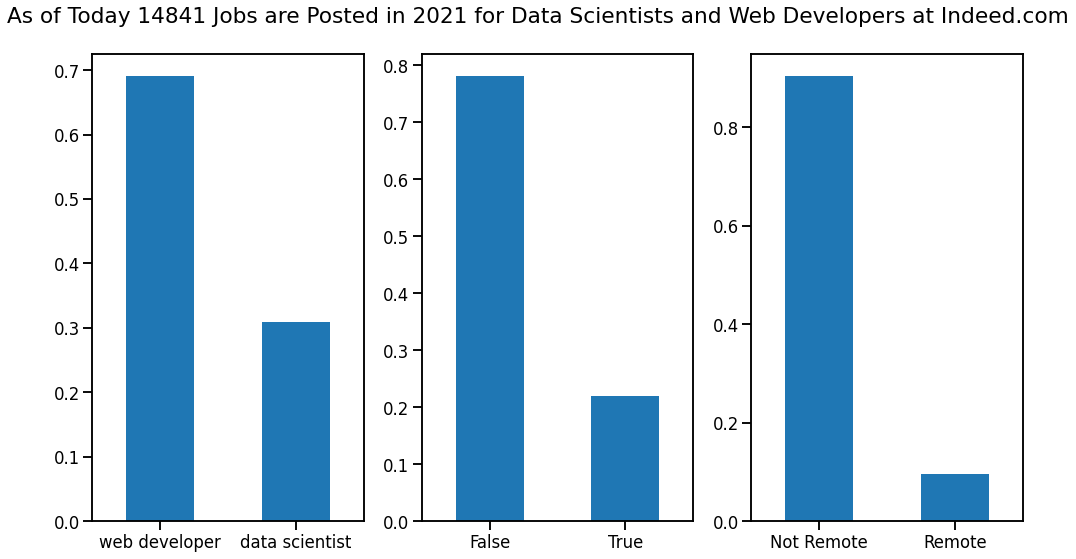

In [39]:
# Set the plotting context parameters
sns.set_context('talk')

fig, axes = plt.subplots(1,3,figsize=(14,8))

df_2021.job_code.value_counts(normalize=True).plot(kind='bar', ax=axes[0], rot="0")
df_2021.repost.value_counts(normalize=True).plot(kind='bar', ax=axes[1], rot="0")
df_2021.city.apply(lambda i: i if i == "Remote" 
                   else "Not Remote").value_counts(normalize=True).plot(kind='bar', ax=axes[2], rot="0")

fig.suptitle("As of Today 14841 Jobs are Posted in 2021 for Data Scientists and Web Developers at Indeed.com")

plt.tight_layout()
plt.show()

**Takeaways**
1. As of today, 14841 jobs have been posted in TX for data scientists and web developers. 
2. About 70% of the jobs are for web developers and 30% for data scientists.
3. Nealry 25% of the jobs are reposted and 8.5% of jobs are remote.

### Where Are the Jobs - Geospatial Analysis

In [40]:
# Remove the remote jobs in 2021

not_remote = (df_2021.city != "Remote")
df_2021_not_remote = df_2021[not_remote]

# Print the number of non-remote jobs
df_2021_not_remote.shape

(13402, 10)

In [41]:
# List the top 10 cities of the highest demand

top10_cities = pd.concat([df_2021_not_remote.city.value_counts().head(10),
                          df_2021_not_remote.city.value_counts(normalize=True).head(10),
                          df_2021_not_remote.city.value_counts(normalize=True).cumsum().head(10)], axis=1)

top10_cities.columns = ['number_of_jobs', 'percent_of_total', 'cumulative_percent_to_total']

top10_cities

,number_of_jobs,percent_of_total,cumulative_percent_to_total
Austin,4475,0.333905,0.333905
Dallas,2135,0.159305,0.493210
Houston,1601,0.119460,0.612670
Plano,1239,0.092449,0.705119
San Antonio,775,0.057827,0.762946
Irving,722,0.053873,0.816818
Fort Worth,310,0.023131,0.839949
Richardson,245,0.018281,0.858230
Lewisville,126,0.009402,0.867632
Round Rock,120,0.008954,0.876586


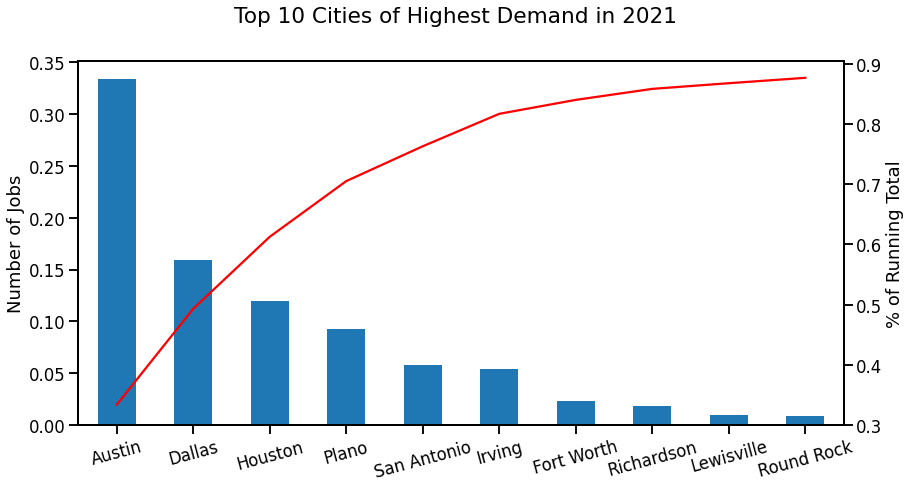

In [42]:
# Visualize the top10 cities by Pareto chart

fig, ax1 = plt.subplots(figsize=(13,7))

# Create a secondary y-axis
ax2 = ax1.twinx()

top10_cities.percent_of_total.plot(kind='bar', ax=ax1, rot='15')
top10_cities.cumulative_percent_to_total.plot(ax=ax2, color='r')

fig.suptitle("Top 10 Cities of Highest Demand in 2021")

ax1.set_ylabel("Number of Jobs")
ax2.set_ylabel("% of Running Total")

ax2.set_yticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

plt.tight_layout()
plt.show()

**Takeaways**
1. About 1/3 of jobs are from companies located in Austin. 
2. The top 10 cities together provide almost 90% of the jobs in the job market in 2021. 

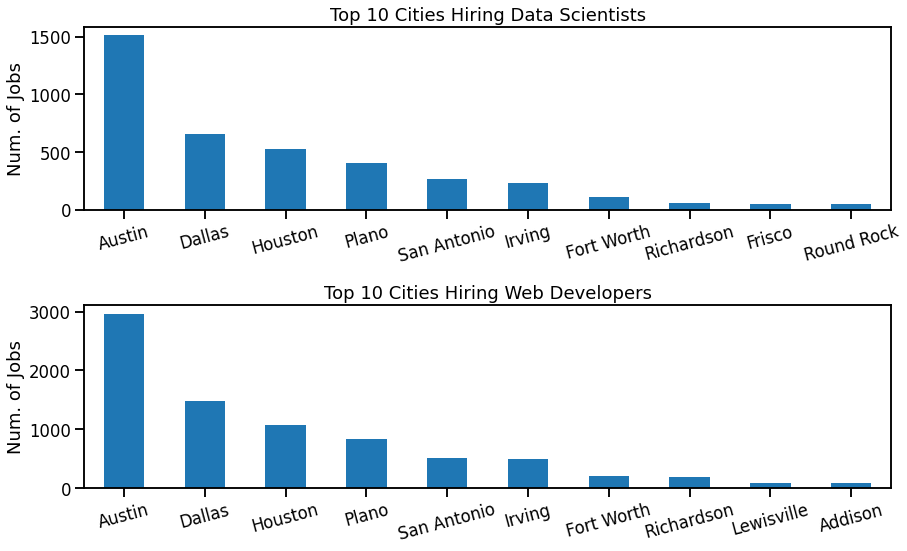

In [43]:
# Compare the top 10 cities that hire data scientists and web developers

# Create a figure and two subplots
fig, axes = plt.subplots(2,1,figsize=(13,8))

df_2021_not_remote_ds = df_2021_not_remote[df_2021_not_remote.job_code == "data scientist"]
df_2021_not_remote_wd = df_2021_not_remote[df_2021_not_remote.job_code == "web developer"]

df_2021_not_remote_ds.city.value_counts().head(10).plot(kind='bar', rot='15', ax=axes[0])
df_2021_not_remote_wd.city.value_counts().head(10).plot(kind='bar', rot='15', ax=axes[1])


# Create the titles
axes[0].set_title("Top 10 Cities Hiring Data Scientists")
axes[1].set_title("Top 10 Cities Hiring Web Developers")

# Create y labels
axes[0].set_ylabel("Num. of Jobs")
axes[1].set_ylabel("Num. of Jobs")

plt.tight_layout()
plt.show()

**Takeaways**:
1. The top 7 cities that hire data scientists are Austin, Dallas, Houston, Plano, San Antonio, Irving, and Fort Worth and it is the exactly the same 7 cities taht hire web developers.
2. The top 7 cities together contributes to 83% of the jobs in the market.

### Who Are Hiring and Who Are Being Hired

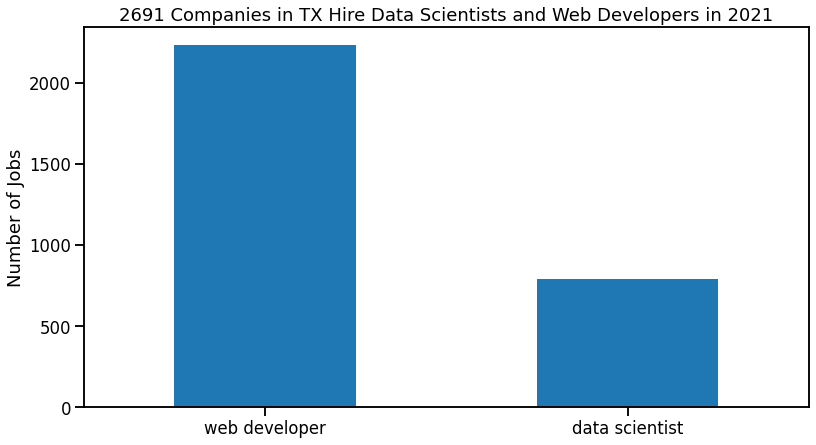

In [44]:
# How many companies hire data scientists and web developers?

# Compute the distinct counts in the `company` column
num_companies = df_2021.company.nunique()

# Group the job postings by the job code and compute the disticnt count in `company` columns 
# And plot the result in a barplot

df_2021.groupby('job_code').company.nunique().sort_values(ascending=False).\
plot(figsize=(13,7), kind='bar', rot=0)

plt.title(f"{num_companies} Companies in TX Hire Data Scientists and Web Developers in 2021")
plt.ylabel("Number of Jobs")
plt.xlabel("")
plt.show()

In [45]:
# How many companies need both and who they are

# Group the job postings by `company` and count the number of distinct job codes in each company
# The comany hires both when the number equals 2

companies_hire_both = df_2021.groupby('company').job_code.nunique()
companies_hire_both = companies_hire_both[companies_hire_both == 2]

print(f"{companies_hire_both.size} companies hire both data scientists and web developer.")
print("Here are 10 of them:")
companies_hire_both.sample(10).index.to_list()

330 companies hire both data scientists and web developer.
Here are 10 of them:


['Calance US',
 'Infomerica inc',
 'Ayata',
 'eBay Inc.',
 'Plus One Robotics',
 'Matlen Silver',
 'USAA',
 'Brinks Home Security',
 'Gainwell Technologies',
 'Mayanalytics, Inc.']

In [46]:
# Group the obervations by their job_code
group_jobcode = df_2021.groupby('job_code')

# Print the groups names
print(group_jobcode.groups.keys())

# Create seperate dataframes for data scientists and web developers
df_2021_ds = group_jobcode.get_group("data scientist")
df_2021_wd = group_jobcode.get_group("web developer")

dict_keys(['data scientist', 'web developer'])


In [47]:
# Compute the top 10 companies posting most data scientist jobs
# And their number of posts

df_2021_ds.company.value_counts().head(10)

JPMorgan Chase Bank, N.A.         159
USAA                              119
IBM                               102
Deloitte                           98
Cognizant Technology Solutions     95
Facebook                           79
Apple                              78
Dell Technologies                  72
KPMG                               68
Amazon.com                         60
Name: company, dtype: int64

In [48]:
# Compute the top 10 companies posting most web developer jobs
# And their number of posts

df_2021_wd.company.value_counts().head(10)

JPMorgan Chase Bank, N.A.              440
CyberCoders                            316
Cognizant Technology Solutions         160
Indeed                                 146
BairesDev                              135
Ad Hoc Team                            130
Infinity Consulting Solutions, Inc.     99
Dell Technologies                       93
Tri-Starr Technology                    73
Home Depot / THD                        71
Name: company, dtype: int64

In [49]:
# Compute the top 10 most popular title for data scientist jobs

df_top10_company_ds = pd.concat([df_2021_ds.job_title.value_counts().head(10),
                                 df_2021_ds.job_title.value_counts(normalize=True).head(10)], axis=1)
df_top10_company_ds.columns=['num_posts', 'percentage']

df_top10_company_ds

,num_posts,percentage
Data Scientist,429,0.093322
Senior Data Scientist,236,0.051338
Senior Data Analyst,136,0.029585
Machine Learning Engineer,93,0.020231
Data Engineer,61,0.013270
Principal Data Scientist,56,0.012182
Senior Statistical Programmer,28,0.006091
Data Scientist II,25,0.005438
Data Science Intern,25,0.005438
Data Science Engineer,24,0.005221


In [50]:
# Compute the top 10 most popular title for web developer jobs

df_top10_company_wd = pd.concat([df_2021_wd.job_title.value_counts().head(10),
                                 df_2021_wd.job_title.value_counts(normalize=True).head(10)], axis=1)
df_top10_company_wd.columns=['num_posts', 'percentage']

df_top10_company_wd

,num_posts,percentage
Web Developer,240,0.023428
Software Engineer,218,0.021281
Senior Software Engineer,202,0.019719
Software Developer,153,0.014936
Full Stack Developer,144,0.014057
Front End Developer,140,0.013667
Java Developer,109,0.010640
UI Developer,96,0.009371
.Net Developer,79,0.007712
Front End Engineer,66,0.006443


**Takeaways**
1. More than 1,800 companies post jobs hiring data scientists and/or web developers, of which 206 hire both. 
2. The top 10 companies are listed seperately for the two posistions.

### Top k Needed Skills

#### Data Scientist Position
- Tech Skills
- Soft Skills
- General Skills (Combination of Tech+Soft)

In [51]:
# Import library
ds_tech_library = library.library_ds_tech

# Print the number of skills in the library
print("Number of data science skills in tech skill library: ", len(ds_tech_library))

# Print the top 5 needed tech skills

ds_top_tech = MVP_explore.top_skills(df_ds, 5, ds_tech_library, 'tech')
ds_top_tech

Number of data science skills in tech skill library:  71
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
ds


,top5_tech_skills,frequency
0,machine learning,7928.0
1,python,4306.0
2,sql,3097.0
3,r,2238.0
4,aws,2109.0


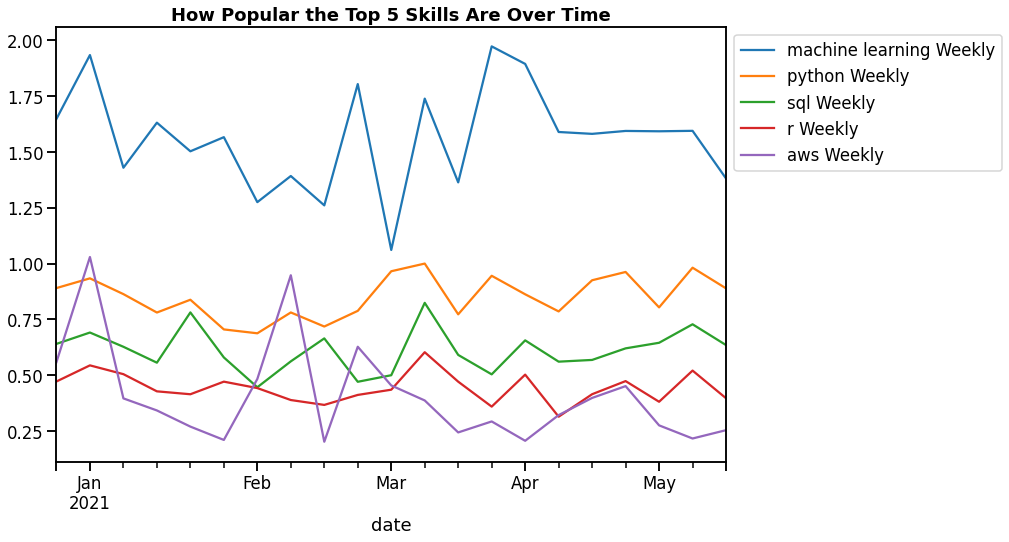

In [52]:
# Plot the how the frequency of the skills per observation change over time

df_ds_skills = MVP_explore.add_skill_frequency(df_ds, ds_top_tech)
MVP_explore.plot_top_skill_ts(df_ds_skills, ds_top_tech)

In [18]:
# Import library
ds_soft_library = library.library_ds_soft

# Print the number of skills in the library
print("Number of data science skills in soft skill library: ", len(ds_soft_library))

# Print the top 5 needed soft skills

ds_top_soft = MVP_explore.top_skills(df_ds, 5, ds_soft_library, 'soft')
ds_top_soft

Number of data science skills in soft skill library:  20
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
ds


,top5_soft_skills,frequency
0,communication,1972.0
1,leadership,1312.0
2,collaboration,572.0
3,problem solving,426.0
4,written communication,330.0


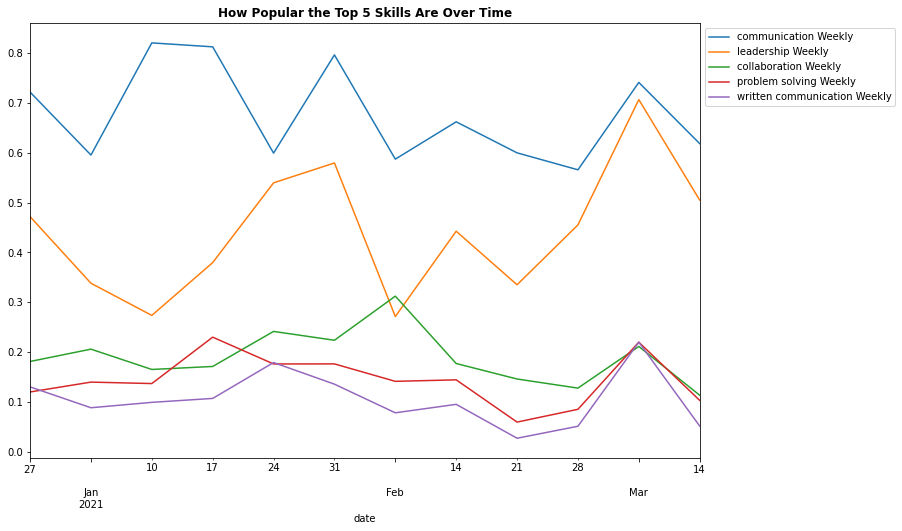

In [19]:
# Plot the how the frequency of the skills per observation change over time

df_ds_skills = MVP_explore.add_skill_frequency(df_ds, ds_top_soft)
MVP_explore.plot_top_skill_ts(df_ds_skills, ds_top_soft)

In [20]:
# Import library
ds_general_library = library.library_ds_general

# Print the number of skills in the library
print("Number of data science skills in general skills library: ", len(ds_general_library))

# Print the top 5 needed general skills

ds_top_general = MVP_explore.top_skills(df_ds, 5, ds_general_library, 'general')
ds_top_general

Number of data science skills in general skills library:  90
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
ds


,top5_general_skills,frequency
0,machine learning,4368.0
1,python,2361.0
2,communication,1972.0
3,sql,1762.0
4,aws,1417.0


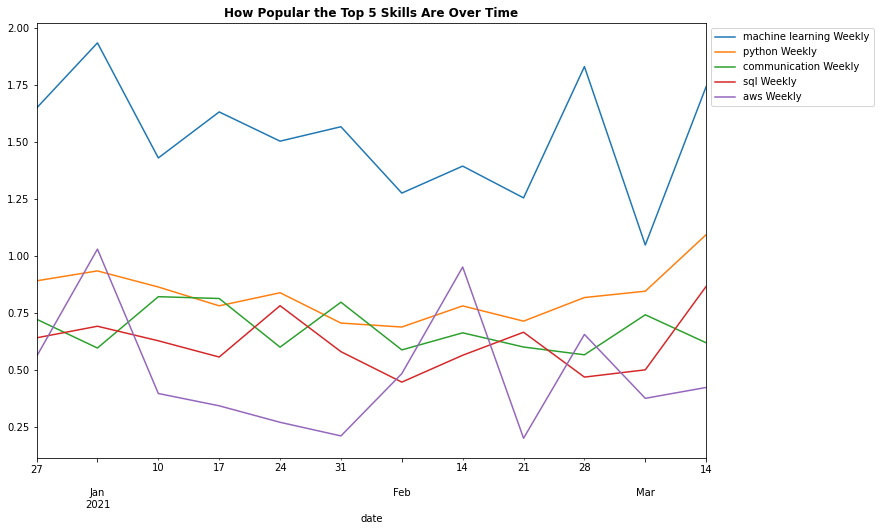

In [21]:
# Plot the how the frequency of the skills per observation change over time

df_ds_skills = MVP_explore.add_skill_frequency(df_ds, ds_top_general)
MVP_explore.plot_top_skill_ts(df_ds_skills, ds_top_general)

#### Web Developer Position
- Tech skills
- Soft skills
- General Skills (Combination of Tech+Soft)

In [22]:
# Import library
wd_tech_library = library.library_wd_tech

# Print the number of skills in the library
print("Number of web dev skills in tech skill library: ", len(wd_tech_library))

# Print the top 5 needed tech skills

wd_top_tech = MVP_explore.top_skills(df_wd, 5, wd_tech_library, 'tech')
wd_top_tech

Number of web dev skills in tech skill library:  67
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
wd


,top5_tech_skills,frequency
0,javascript,4511.0
1,java,3037.0
2,sql,2741.0
3,react,2438.0
4,c,2263.0


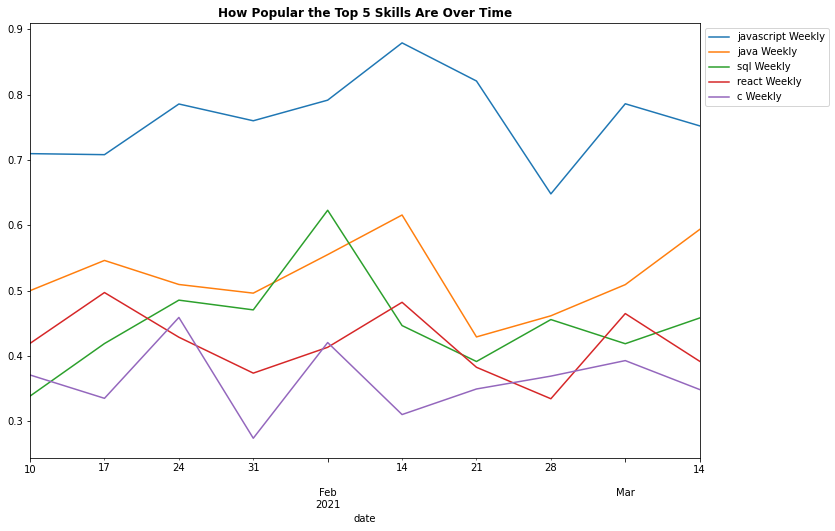

In [23]:
# Plot the how the frequency of the skills per observation change over time

df_wd_skills = MVP_explore.add_skill_frequency(df_wd, wd_top_tech)
MVP_explore.plot_top_skill_ts(df_wd_skills, wd_top_tech)

In [24]:
# Import library
wd_soft_library = library.library_wd_soft

# Print the number of skills in the library
print("Number of web dev skills in soft skill library: ", len(wd_soft_library))

# Print the top 5 needed soft skills

wd_top_soft = MVP_explore.top_skills(df_wd, 5, wd_soft_library, 'soft')
wd_top_soft

Number of web dev skills in soft skill library:  20
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
wd


,top5_soft_skills,frequency
0,communication,3365.0
1,leadership,1306.0
2,collaboration,896.0
3,problem solving,711.0
4,written communication,504.0


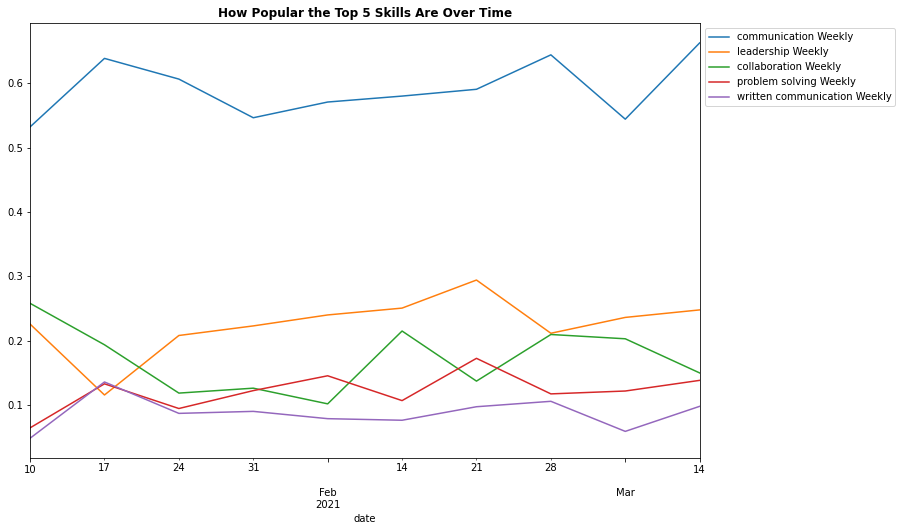

In [25]:
# Plot the how the frequency of the skills per observation change over time

df_wd_skills = MVP_explore.add_skill_frequency(df_wd, wd_top_soft)
MVP_explore.plot_top_skill_ts(df_wd_skills, wd_top_soft)

In [26]:
# Import library
wd_general_library = library.library_wd_general

# Print the number of skills in the library
print("Number of web dev skills in general skill library: ", len(wd_general_library))

# Print the top 5 needed general skills

wd_top_general = MVP_explore.top_skills(df_wd, 5, wd_general_library, 'general')
wd_top_general

Number of web dev skills in general skill library:  86
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
wd


,top5_general_skills,frequency
0,javascript,4511.0
1,communication,3365.0
2,java,3037.0
3,sql,2741.0
4,react,2438.0


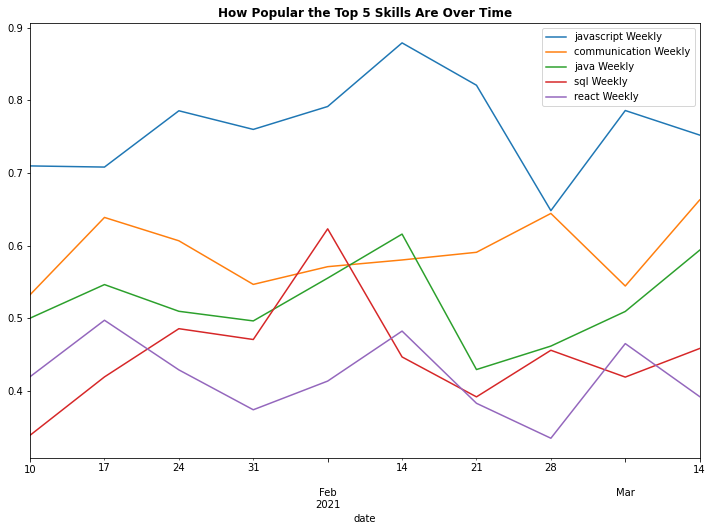

In [27]:
# Plot the how the frequency of the skills per observation change over time

df_wd_skills = MVP_explore.add_skill_frequency(df_wd, wd_top_general)
MVP_explore.plot_top_skill_ts(df_wd_skills, wd_top_general)